# GWAS Tutorial

This notebook runs an example analysis of GWAS (genome-wide association study) data to identify variants significantly associated with beat synchronization. First, you will characterize the data and perform any needed filtering. Second, you will calculate GWAS summary statistics. Third, you will generate a Manhattan plot and identify significant peaks.

Let's load the necessary libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

Read in the pedigree data (with genotypes) and map formatted data.

In [2]:
variant_info = pd.read_csv('GWAS_tutorial.map.gz', sep = '\t', header = 0)
genotypes = pd.read_csv('GWAS_tutorial.ped.gz', sep = '\t', header = 0)

Take a look at both files.

In [3]:
variant_info.head()

,chr,rsID,cM,pos
0,1,rs1_1,0,200826415
1,1,rs1_2,0,4027976
2,1,rs1_3,0,222620360
3,1,rs1_4,0,5556784
4,1,rs1_5,0,176260783


In [4]:
genotypes.head()

,FID,IID,Father_ID,Mother_ID,Sex,PHENOTYPE,rs1_1,rs1_2,rs1_3,rs1_4,...,rsX_510,rsX_511,rsX_512,rsX_513,rsX_514,rs848293,rs10779987,rs62340585,rs11865086,rs4792891
0,0,IND0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,2,0,1,1,0
1,0,IND1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,2,1,1
2,0,IND2,0,0,0,0,1,0,0,0,...,0,0,1,1,0,0,1,1,1,2
3,0,IND3,0,0,0,0,1,0,0,0,...,1,1,0,0,0,1,1,0,1,0
4,0,IND4,0,0,0,0,2,0,1,0,...,0,0,2,2,0,1,0,0,0,1


Check how many rows in are the .map file. Then use the same command to see how many rows are contained in .ped file.

In [5]:
len(variant_info)

9994

In [6]:
 # Type code for finding the length of the .ped file here

<span style="color:green">**Question**:</span> How many variants are present in the data? How many different individuals?

Now let's consider the phenotype we are investigating: beat synchronization. Let's count the values present in the phenotype column of the .ped file.

In [7]:
genotypes['PHENOTYPE'].value_counts()

PHENOTYPE
1    25000
0    25000
Name: count, dtype: int64

<span style="color:green">**Question**:</span> If study participants were asked "Can you clap in time with a musical beat?", what do you think the 0s and 1s represent in the data? Would you characterize this study design as "balanced" or "unbalanced" based on the distribution of phenotypes?

<span style="color:purple">**Checkpoint**:</span> Pause here and touch base with the activity leader.

Some variants are very rare in humans. When conducting GWAS, we are less likely to be able to detect the effects of these rare variants without a very large sample size. Therefore, it is common practice in GWAS to exclude variants that are low frequency. We first calculate the <span style="color:orange">**minor allele frequency**</span> or <span style="color:orange">**MAF**</span> for each variant and then filter the data based on some value. Let's first write a function that calculates the MAF for all variants.

In [8]:
def calculate_MAF(df, snp_start_col = 7):
    MAFs = []
    snps = df.columns[snp_start_col:]
    
    for column in snps:
        allele_counts = df[column].value_counts()
        count_0 = allele_counts.get(0, 0)
        count_1 = allele_counts.get(1, 0)
        count_2 = allele_counts.get(2, 0)
        
        total_alleles = 2 * (count_0 + count_1 + count_2)
        freq_allele_0 = (2 * count_0 + count_1) / total_alleles
        freq_allele_1 = (2 * count_2 + count_1) / total_alleles
        
        MAF = min(freq_allele_0, freq_allele_1)
        MAFs.append({'SNP': column, 'MAF': MAF})
    
    MAF_df = pd.DataFrame(MAFs)
    return MAF_df

In [9]:
MAFs = calculate_MAF(genotypes)

Let's count the number of variants whose minor allele frequency is less than 5%. Edit the code below to do this.

In [10]:
#len(MAFs[MAFs['MAF'] # add filtering criteria here])

We should remove those variants from the dataframe.

In [11]:
low_MAF_variants = MAFs[MAFs['MAF'] < 0.05]['SNP']
genotypes_filtered = genotypes.drop(columns = low_MAF_variants)

Let's double check the length of the filtered genotypes file.

In [12]:
genotypes_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 9160 entries, FID to rs4792891
dtypes: int64(9159), object(1)
memory usage: 3.4+ GB


<span style="color:purple">**Checkpoint**:</span> Pause here and touch base with the activity leader.

Now it's time to calculate summary statistics for each variant. Here, and for most GWAS, we are concerned with two statistics: the <span style="color:orange">**odds ratio (OR)**</span> and <span style="color:orange">**p-value**</span>.

The <span style="color:orange">**odds ratio**</span> is interpreted as the ratio of the odds of an individual having a phenotype associated with a specific allele and the odds of the same phenotype for an individual who does not have the same allele. In practice, an odds ratio of 1 means the variant has no or minimal affect on the phenotype, whereas values greater than one indicate the variant increases "risk" for a trait and values less than one decrease "risk" for a trait.

A <span style="color:orange">**p-value**</span> is a statistic that represents the probability of obtaining a statistical test result that is at least as extreme as the observed result. We use this measure to assess whether the patterns in our observed data are due to random chance. Generally, we consider a p-value less than 0.05 to be significant or not due to random chance. In GWAS, a stricter p-value is used because we are performing thousands of tests, of which many could be due to random chance. Here, we will use a p-value of 0.00000005 or 5 x 10^-8.

First, we will start with the function to calculate the summary statistics.

In [13]:
def calculate_GWAS_summary_stats(ped_file):
    # Read PED file
    df = ped_file
 
    # Extract phenotype and genotypes
    phenotypes = df.iloc[:, 5].astype(int)
    genotypes = df.iloc[:, 6:].astype(int)
    
    # Initialize lists to store results
    snp_ids = genotypes.columns.tolist()
    allele_freqs = []
    odds_ratios = []
    p_values = []

    # Loop through each SNP
    for snp in snp_ids:
        snp_genotypes = genotypes[snp]

        # Calculate allele frequencies
        allele_freq = snp_genotypes.mean() / 2
        allele_freqs.append(allele_freq)
        
        # Logistic regression for association testing
        X = sm.add_constant(snp_genotypes)
        model = sm.Logit(phenotypes, X)
        result = model.fit(disp=0)
        
        # Get beta, odds ratio, and p-value
        beta = result.params[snp]
        odds_ratio = np.exp(beta)
        p_value = result.pvalues[snp]
        
        odds_ratios.append(odds_ratio)
        p_values.append(p_value)

    # Create summary statistics dataframe
    summary_stats = pd.DataFrame({
        'rsID': snp_ids,
        'AF': allele_freqs,
        'OR': odds_ratios,
        'p_value': p_values
    })

    return summary_stats

Run the function on the genotypes.

In [14]:
summary_stats = calculate_GWAS_summary_stats(genotypes)

Let's take a peak at that object.

In [15]:
summary_stats.head()

,rsID,AF,OR,p_value
0,rs1_1,0.42803,1.007793,0.543708
1,rs1_2,0.06738,1.002552,0.919577
2,rs1_3,0.18924,0.991229,0.584180
3,rs1_4,0.05474,0.975482,0.372813
4,rs1_5,0.12379,0.986310,0.472171


We need to map the chromosome and position on to the SNP ID in our summary statistics, modify the dataframe slightly, and then we will visualize the data.

In [16]:
variant_chr_dict = dict(zip(variant_info['rsID'], variant_info['chr']))
variant_pos_dict = dict(zip(variant_info['rsID'], variant_info['pos']))

summary_stats['chr'] = summary_stats['rsID'].map(variant_chr_dict)
summary_stats['chr'] = 'chr' + summary_stats['chr']
summary_stats['pos'] = summary_stats['rsID'].map(variant_pos_dict)

summary_stats['chr'] = pd.Categorical(summary_stats['chr'], ['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22','chrX'])
summary_stats = summary_stats.sort_values(['chr','pos'])

summary_stats['-log10_p_value'] = -np.log10(summary_stats['p_value'])
summary_stats['cumulative_pos'] = range(len(summary_stats))

Let's take another look at the new summary statistics object before we plot.

In [17]:
summary_stats.head()

,rsID,AF,OR,p_value,chr,pos,-log10_p_value,cumulative_pos
423,rs1_424,0.29836,0.999041,0.944769,chr1,68659,0.024674,0
442,rs1_443,0.33260,0.994457,0.678073,chr1,251367,0.168724,1
525,rs1_526,0.27151,0.988641,0.421751,chr1,736502,0.374944,2
349,rs1_350,0.28710,1.020088,0.154370,chr1,1080424,0.811436,3
602,rs1_603,0.32667,0.980019,0.135348,chr1,1603557,0.868550,4


<span style="color:purple">**Checkpoint**:</span> Pause here and touch base with the activity leader.

Time to plot!

/var/folders/1q/tkwxqjdd5p55p8zj44_g4yjc0000gn/T/ipykernel_2326/1987648627.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chromosome_ranges = summary_stats.groupby('chr')['cumulative_pos'].agg(['min', 'max'])


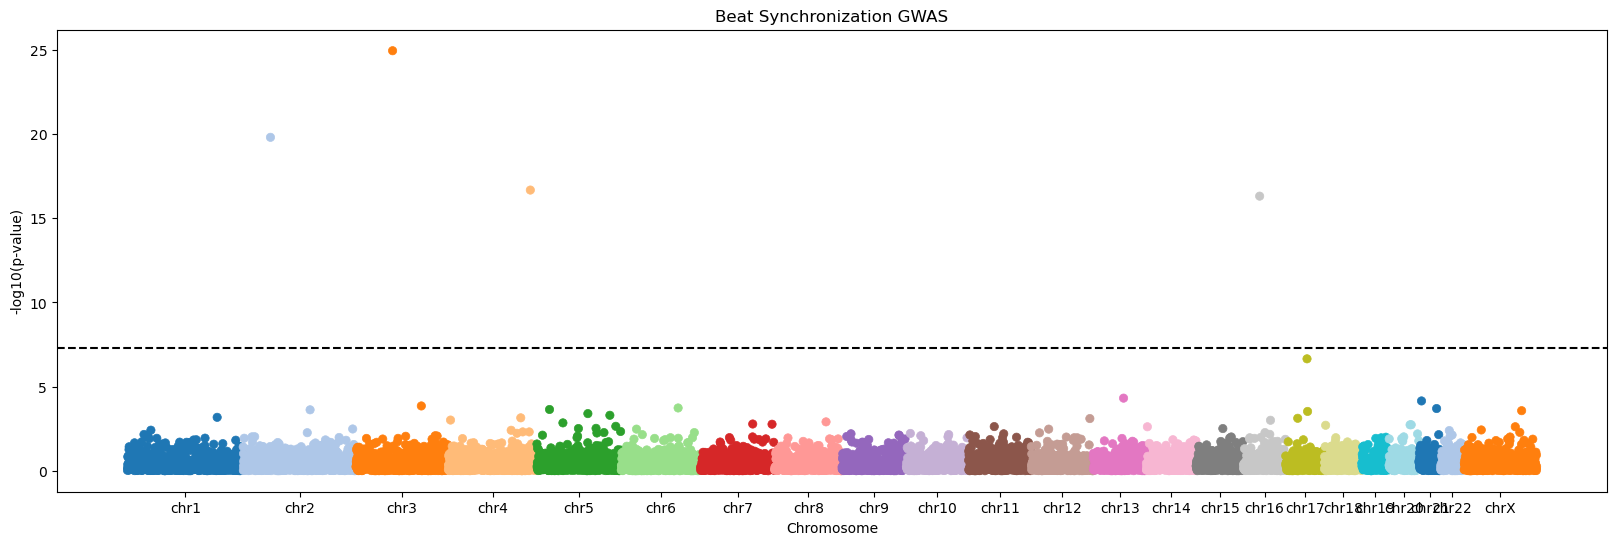

In [18]:
base_palette = sns.color_palette("viridis", 7)
extended_palette = (base_palette * (23 // 7 + 1))[:23]

plt.figure(figsize = (20, 6))
sns.scatterplot(data = summary_stats, x = 'cumulative_pos', y = '-log10_p_value', hue = 'chr', palette = 'tab20', edgecolor = None, legend = False)
plt.xlabel('Chromosome')
plt.ylabel('-log10(p-value)')
plt.title('Beat Synchronization GWAS')

chromosome_ranges = summary_stats.groupby('chr')['cumulative_pos'].agg(['min', 'max'])
chromosome_midpoints = (chromosome_ranges['min'] + chromosome_ranges['max']) / 2

# Set x-ticks to the midpoints of chromosomes and label them
plt.xticks(ticks = chromosome_midpoints, labels= [chr for chr in chromosome_midpoints.index])

# Add a genome-wide significance line (adjust significance threshold as needed)
genome_wide_significance = -np.log10(5e-8)  # Example threshold
plt.axhline(y = genome_wide_significance, color = 'black', linestyle = '--')

plt.show()

<span style="color:green">**Question**:</span> How many variants pass the genome-wide threshold for significance?

Let's look at the variants in the summary statistics dataframe.

In [19]:
summary_stats[summary_stats['p_value'] < 0.00000005]

,rsID,AF,OR,p_value,chr,pos,-log10_p_value,cumulative_pos
9989,rs848293,0.42448,1.115382,1.539571e-20,chr2,58155355,19.812600,1014
9990,rs10779987,0.42523,1.131550,1.100377e-25,chr3,81921705,24.958459,1880
9991,rs62340585,0.42429,1.104897,2.099997e-17,chr4,175949971,16.677781,2857
9992,rs11865086,0.42464,1.103818,4.821300e-17,chr16,30119172,16.316836,8029


<span style="color:green">**Question**:</span> Do the variants increase "risk" or decrease "risk" for beat synchronization? Using the rsID or chromosome and position, look up whether these variants occur in or nearby genes. If the variants are near genes, do the genes make sense given the trait? For example, a GWAS of infection status would likely identify variants associated with the immune system.